In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [3]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [4]:
# structures = ['7N', '12N']
# labels_to_sample = structures + map(convert_to_surround_name, structures)
# labels_to_sample = structures + [convert_to_surround_name(l, surr_l) for l in structures for surr_l in structures + ['noclass'] if surr_l != l]
# labels_to_sample = structures + [l + '_negative' for l in structures]
labels_to_sample = structures + [l + '_negative' for l in structures] + \
[convert_to_surround_name(l, margin=m, suffix=surr_l) for m in [100,200,300,400,500,600,700,800,900,1000]
 for l in structures for surr_l in structures + ['noclass'] if surr_l != l] + \
['noclass']

# Training

In [5]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels = set([])

# for stack in ['MD589', 'MD585', 'MD594']:
for stack in ['MD635']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, num_samples_per_landmark=1000)
    
    for name, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

In [6]:
# # Optional, if no need to sample training patches

# labels = set([])

# # for stack in ['MD589', 'MD585', 'MD594']:
# for stack in ['MD635']:
#     annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
#     label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
#     labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
#     labels = labels | labels_this_stack

In [6]:
existing_names = set([convert_to_original_name(l) for l in labels]) - {'noclass'}

In [8]:
first_sec, last_sec = metadata_cache['section_limits'][stack]
s2f = metadata_cache['sections_to_filenames'][stack]

In [16]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

('MD635', 75)
('MD635', 76)
('MD635', 77)
('MD635', 78)
('MD635', 79)
('MD635', 80)
('MD635', 81)
('MD635', 82)


Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @33544
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @32038
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30531
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @35297


('MD635', 83)


Patch in annotation but not in mask: MD635 83 MD635-F28-2016.05.18-21.46.26_MD635_2_0083 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @206


('MD635', 84)
('MD635', 85)
('MD635', 86)
('MD635', 87)
('MD635', 88)
('MD635', 89)


Patch in annotation but not in mask: MD635 89 MD635-F30-2016.05.18-22.15.39_MD635_2_0089 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @159


('MD635', 90)
('MD635', 91)


Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @148
Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @104
Patch in annotation but not in mask: MD635 91 MD635-F31-2016.05.18-22.31.18_MD635_1_0091 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @227


('MD635', 92)


Patch in annotation but not in mask: MD635 92 MD635-F31-2016.05.18-22.31.18_MD635_2_0092 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @196


('MD635', 94)


Patch in annotation but not in mask: MD635 94 MD635-F32-2016.05.18-22.50.16_MD635_1_0094 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @35


('MD635', 95)


Patch in annotation but not in mask: MD635 95 MD635-F32-2016.05.18-22.50.16_MD635_2_0095 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @47


('MD635', 96)


Patch in annotation but not in mask: MD635 96 MD635-F32-2016.05.18-22.50.16_MD635_3_0096 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @216


('MD635', 97)
('MD635', 98)
('MD635', 99)


Patch in annotation but not in mask: MD635 99 MD635-F33-2016.05.18-23.06.34_MD635_3_0099 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @224
Patch in annotation but not in mask: MD635 99 MD635-F33-2016.05.18-23.06.34_MD635_3_0099 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @94


('MD635', 100)


Patch in annotation but not in mask: MD635 100 MD635-F34-2016.05.18-23.23.55_MD635_1_0100 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @167


('MD635', 101)
('MD635', 102)
('MD635', 103)


Patch in annotation but not in mask: MD635 103 MD635-F35-2016.05.18-23.40.52_MD635_1_0103 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @52


('MD635', 104)


Patch in annotation but not in mask: MD635 104 MD635-F35-2016.05.18-23.40.52_MD635_2_0104 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @55
Patch in annotation but not in mask: MD635 104 MD635-F35-2016.05.18-23.40.52_MD635_2_0104 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @77


('MD635', 105)
('MD635', 106)
('MD635', 107)


Patch in annotation but not in mask: MD635 107 MD635-F36-2016.05.18-23.59.35_MD635_2_0107 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @124


('MD635', 108)
('MD635', 109)
('MD635', 110)
('MD635', 111)
('MD635', 112)
('MD635', 113)
('MD635', 114)


Patch in annotation but not in mask: MD635 114 MD635-F38-2016.05.19-00.34.28_MD635_3_0114 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @196
Patch in annotation but not in mask: MD635 114 MD635-F38-2016.05.19-00.34.28_MD635_3_0114 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @217


('MD635', 115)


Patch in annotation but not in mask: MD635 115 MD635-F39-2016.05.19-00.52.10_MD635_1_0115 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @51
Patch in annotation but not in mask: MD635 115 MD635-F39-2016.05.19-00.52.10_MD635_1_0115 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @107
Patch in annotation but not in mask: MD635 115 MD635-F39-2016.05.19-00.52.10_MD635_1_0115 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @89


('MD635', 116)


Patch in annotation but not in mask: MD635 116 MD635-F39-2016.05.19-00.52.10_MD635_2_0116 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @219
Patch in annotation but not in mask: MD635 116 MD635-F39-2016.05.19-00.52.10_MD635_2_0116 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41
Patch in annotation but not in mask: MD635 116 MD635-F39-2016.05.19-00.52.10_MD635_2_0116 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @60


('MD635', 117)


Patch in annotation but not in mask: MD635 117 MD635-F39-2016.05.19-00.52.10_MD635_3_0117 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @111


('MD635', 118)
('MD635', 119)


Patch in annotation but not in mask: MD635 119 MD635-F40-2016.05.19-01.08.51_MD635_2_0119 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @167


('MD635', 120)
('MD635', 121)
('MD635', 122)
('MD635', 123)
('MD635', 124)
('MD635', 125)
('MD635', 126)
('MD635', 127)
('MD635', 128)


Patch in annotation but not in mask: MD635 128 MD635-F43-2016.05.19-02.06.14_MD635_2_0128 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @220


('MD635', 129)


Patch in annotation but not in mask: MD635 129 MD635-F43-2016.05.19-02.06.14_MD635_3_0129 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @161


('MD635', 130)


Patch in annotation but not in mask: MD635 130 MD635-F44-2016.05.19-02.24.57_MD635_1_0130 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @32


('MD635', 131)
('MD635', 132)
('MD635', 133)
('MD635', 134)
('MD635', 135)
('MD635', 136)
('MD635', 137)
('MD635', 138)
('MD635', 139)


Patch in annotation but not in mask: MD635 139 MD635-F47-2016.05.19-03.19.48_MD635_1_0139 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @48


('MD635', 140)


Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @42102
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @42603
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @126


('MD635', 141)


Patch in annotation but not in mask: MD635 141 MD635-F47-2016.05.19-03.19.48_MD635_3_0141 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41


('MD635', 142)
('MD635', 143)
('MD635', 144)
('MD635', 145)


Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @176


('MD635', 146)
('MD635', 147)
('MD635', 148)


Patch in annotation but not in mask: MD635 148 MD635-F50-2016.05.23-14.45.07_MD635_1_0148 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @135


('MD635', 149)


Patch in annotation but not in mask: MD635 149 MD635-F50-2016.05.23-14.45.07_MD635_2_0149 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @71
Patch in annotation but not in mask: MD635 149 MD635-F50-2016.05.23-14.45.07_MD635_2_0149 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @228


('MD635', 150)


Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @56


('MD635', 151)


Patch in annotation but not in mask: MD635 151 MD635-F51-2016.05.23-15.04.39_MD635_1_0151 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @160


('MD635', 152)
('MD635', 153)


Patch in annotation but not in mask: MD635 153 MD635-F51-2016.05.23-15.04.39_MD635_3_0153 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @225


('MD635', 154)


Patch in annotation but not in mask: MD635 154 MD635-F52-2016.05.23-15.23.47_MD635_1_0154 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @200


('MD635', 155)


Patch in annotation but not in mask: MD635 155 MD635-F52-2016.05.19-04.56.12_MD635_2_0155 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @172


('MD635', 156)


Patch in annotation but not in mask: MD635 156 MD635-F52-2016.05.23-15.23.47_MD635_3_0156 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @135


('MD635', 157)
('MD635', 158)
('MD635', 159)


Patch in annotation but not in mask: MD635 159 MD635-F53-2016.05.19-05.14.50_MD635_3_0159 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @156


('MD635', 160)
('MD635', 161)


Patch in annotation but not in mask: MD635 161 MD635-F54-2016.05.19-05.34.49_MD635_3_0162 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @204


('MD635', 162)
('MD635', 163)


Patch in annotation but not in mask: MD635 163 MD635-F55-2016.05.23-16.24.34_MD635_3_0165 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20
Patch in annotation but not in mask: MD635 163 MD635-F55-2016.05.23-16.24.34_MD635_3_0165 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @90


('MD635', 164)
('MD635', 165)
('MD635', 166)
('MD635', 167)


Patch in annotation but not in mask: MD635 167 MD635-F57-2016.05.19-06.32.00_MD635_2_0170 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @10040


('MD635', 168)
('MD635', 169)


Patch in annotation but not in mask: MD635 169 MD635-F58-2016.05.19-06.52.57_MD635_2_0173 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @85
Patch in annotation but not in mask: MD635 169 MD635-F58-2016.05.19-06.52.57_MD635_2_0173 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @38


('MD635', 170)
('MD635', 171)


Patch in annotation but not in mask: MD635 171 MD635-F59-2016.05.19-07.14.24_MD635_2_0176 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @186


('MD635', 172)
('MD635', 173)
('MD635', 174)
('MD635', 175)
('MD635', 176)
('MD635', 177)
('MD635', 178)


Patch in annotation but not in mask: MD635 178 MD635-F63-2016.05.19-08.39.03_MD635_1_0187 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @57


('MD635', 179)


Patch in annotation but not in mask: MD635 179 MD635-F63-2016.05.19-08.39.03_MD635_2_0188 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @26
Patch in annotation but not in mask: MD635 179 MD635-F63-2016.05.19-08.39.03_MD635_2_0188 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @192


('MD635', 180)
('MD635', 181)


Patch in annotation but not in mask: MD635 181 MD635-F64-2016.05.19-09.00.59_MD635_2_0191 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @120


('MD635', 182)
('MD635', 183)
('MD635', 184)
('MD635', 185)
('MD635', 186)


Patch in annotation but not in mask: MD635 186 MD635-F67-2016.05.19-09.59.06_MD635_1_0199 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21


('MD635', 187)
('MD635', 188)


Patch in annotation but not in mask: MD635 188 MD635-F68-2016.05.19-10.18.40_MD635_1_0202 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @165


('MD635', 189)
('MD635', 190)
('MD635', 191)
('MD635', 192)


Patch in annotation but not in mask: MD635 192 MD635-F70-2016.05.19-10.57.59_MD635_1_0208 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @72


('MD635', 193)


Patch in annotation but not in mask: MD635 193 MD635-F70-2016.05.19-10.57.59_MD635_2_0209 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @136


('MD635', 194)


Patch in annotation but not in mask: MD635 194 MD635-F71-2016.05.19-11.17.07_MD635_1_0211 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @176


('MD635', 195)
('MD635', 196)


Patch in annotation but not in mask: MD635 196 MD635-F72-2016.05.19-11.37.07_MD635_1_0214 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @108


('MD635', 197)


Patch in annotation but not in mask: MD635 197 MD635-F72-2016.05.19-11.37.07_MD635_2_0215 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @103


('MD635', 198)


Patch in annotation but not in mask: MD635 198 MD635-F73-2016.05.19-11.56.44_MD635_1_0217 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @231


('MD635', 199)


Patch in annotation but not in mask: MD635 199 MD635-F73-2016.05.19-11.56.44_MD635_2_0218 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @35


('MD635', 200)


Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21533
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @23044
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20782
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21032
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @22043
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21036
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo 

('MD635', 201)
('MD635', 202)


Patch in annotation but not in mask: MD635 202 MD635-F75-2016.05.19-12.32.46_MD635_1_0223 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @120
Patch in annotation but not in mask: MD635 202 MD635-F75-2016.05.19-12.32.46_MD635_1_0223 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @198
Patch in annotation but not in mask: MD635 202 MD635-F75-2016.05.19-12.32.46_MD635_1_0223 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @174


('MD635', 203)


Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @187
Patch in annotation but not in mask: MD635 203 MD635-F75-2016.05.19-12.32.46_MD635_2_0224 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @53


('MD635', 204)


Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @114


('MD635', 206)


Patch in annotation but not in mask: MD635 206 MD635-F77-2016.05.19-13.07.42_MD635_1_0229 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @230
Patch in annotation but not in mask: MD635 206 MD635-F77-2016.05.19-13.07.42_MD635_1_0229 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @155


('MD635', 207)


Patch in annotation but not in mask: MD635 207 MD635-F77-2016.05.19-13.07.42_MD635_2_0230 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @60


('MD635', 208)
('MD635', 209)
('MD635', 210)
('MD635', 211)


Patch in annotation but not in mask: MD635 211 MD635-F79-2016.05.19-13.44.43_MD635_2_0236 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @231
Patch in annotation but not in mask: MD635 211 MD635-F79-2016.05.19-13.44.43_MD635_2_0236 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @176


('MD635', 212)


Patch in annotation but not in mask: MD635 212 MD635-F80-2016.05.19-14.03.50_MD635_1_0238 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @186
Patch in annotation but not in mask: MD635 212 MD635-F80-2016.05.19-14.03.50_MD635_1_0238 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @140


('MD635', 213)
('MD635', 214)
('MD635', 216)


Patch in annotation but not in mask: MD635 216 MD635-F82-2016.05.19-14.39.57_MD635_1_0244 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @209


('MD635', 217)
('MD635', 218)
('MD635', 219)
('MD635', 220)
('MD635', 221)


Patch in annotation but not in mask: MD635 221 MD635-F84-2016.05.19-15.18.11_MD635_2_0251 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @60


('MD635', 222)
('MD635', 223)


Patch in annotation but not in mask: MD635 223 MD635-F85-2016.05.19-15.36.47_MD635_2_0254 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @191


('MD635', 224)
('MD635', 225)


Patch in annotation but not in mask: MD635 225 MD635-F86-2016.05.19-15.55.34_MD635_2_0257 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @200


('MD635', 226)
('MD635', 227)


Patch in annotation but not in mask: MD635 227 MD635-F87-2016.05.19-16.15.25_MD635_2_0260 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @139


('MD635', 228)
('MD635', 229)


Patch in annotation but not in mask: MD635 229 MD635-F88-2016.05.19-16.34.48_MD635_2_0263 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @57


('MD635', 230)
('MD635', 231)


Patch in annotation but not in mask: MD635 231 MD635-F89-2016.05.19-16.53.54_MD635_2_0266 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @118
Patch in annotation but not in mask: MD635 231 MD635-F89-2016.05.19-16.53.54_MD635_2_0266 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @169


('MD635', 233)
('MD635', 234)


Patch in annotation but not in mask: MD635 234 MD635-F91-2016.05.19-17.33.31_MD635_1_0271 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @129


('MD635', 235)


Patch in annotation but not in mask: MD635 235 MD635-F91-2016.05.19-17.33.31_MD635_2_0272 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @57


('MD635', 236)


Patch in annotation but not in mask: MD635 236 MD635-F92-2016.05.19-17.52.45_MD635_1_0274 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @91


('MD635', 237)
('MD635', 238)
('MD635', 239)


Patch in annotation but not in mask: MD635 239 MD635-F93-2016.05.19-18.12.24_MD635_2_0278 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @175


('MD635', 240)


In [26]:
# Remove addresses whose features are None
for name in labels:
    valid = [(ftr, addr) for ftr, addr in zip(training_features[name], training_addresses[name])
                if ftr is not None]
    res = zip(*valid)
    training_features[name] = np.array(res[0])
    training_addresses[name] = res[1]

In [30]:
for name in sorted(training_addresses.iterkeys()):
    print name, len(training_addresses[name])

10N 1000
10N_negative 999
10N_surround_1000_12N 1000
10N_surround_1000_AP 292
10N_surround_1000_noclass 1000
10N_surround_100_12N 78
10N_surround_100_noclass 1000
10N_surround_200_12N 1000
10N_surround_200_noclass 1000
10N_surround_300_12N 1000
10N_surround_300_noclass 1000
10N_surround_400_12N 1000
10N_surround_400_AP 13
10N_surround_400_noclass 1000
10N_surround_500_12N 1000
10N_surround_500_AP 76
10N_surround_500_noclass 1000
10N_surround_600_12N 1000
10N_surround_600_AP 124
10N_surround_600_noclass 1000
10N_surround_700_12N 1000
10N_surround_700_AP 164
10N_surround_700_noclass 1000
10N_surround_800_12N 1000
10N_surround_800_AP 207
10N_surround_800_noclass 1000
10N_surround_900_12N 1000
10N_surround_900_AP 246
10N_surround_900_noclass 1000
12N 1000
12N_negative 995
12N_surround_1000_10N 1000
12N_surround_1000_AP 923
12N_surround_1000_noclass 1000
12N_surround_100_10N 89
12N_surround_100_noclass 1000
12N_surround_200_10N 1000
12N_surround_200_noclass 1000
12N_surround_300_10N 1000
12

In [10]:
contours_original, _ = DataManager.load_annotation_v3(stack=stack, annotation_rootdir=ANNOTATION_ROOTDIR)
contours_aligned_cropped = convert_annotation_v3_original_to_aligned_cropped(contours_original, stack=stack)

structure_centers_all_secs_all_names = defaultdict(dict)

for sec in range(first_sec, last_sec+1):

    fn = s2f[sec]
    if fn in ['Nonexisting', 'Rescan', 'Placeholder']:
        continue
        
    contours_this_sec = contours_aligned_cropped[contours_aligned_cropped['filename'] == fn]

    for name_u in set(contours_this_sec['name']):
        matched_contours = contours_this_sec[(contours_this_sec['name'] == name_u)]
#         assert len(matched_contours) == 1 # will fail because the bug in GUI that creates multiple duplicate entries for the same contour
        cnt = matched_contours.iloc[0]
        center = cnt['vertices'].mean(axis=0)
        structure_centers_all_secs_all_names[sec][name_u] = center
        
structure_centers_all_secs_all_names.default_factory = None

'No object named structures in the file'


Annotation has no structures.


In [29]:
distances_to_structures = apply_function_to_dict(lambda addrs:\
                                                 addresses_to_structure_distances(addrs, structure_centers_all_secs_all_names), 
                                                training_addresses)

import pandas
distances_to_structures = {label: pandas.DataFrame(distances) for label, distances in distances_to_structures.iteritems()}

In [31]:
if stack in ['MD635']:
    train_feat_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'training_features/'))
else:
    train_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'training_features/'))

In [32]:
# Save training features
for name, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name + '.bp'))

In [34]:
# Save training addresses
if stack in ['MD635']:
    save_pickle(training_addresses, os.path.join(SVM_NTBLUE_ROOTDIR, 'training_addresses.pkl'))
else:
    save_pickle(training_addresses, os.path.join(SVM_ROOTDIR, 'training_addresses.pkl'))

In [ ]:
# Load training features
training_features = {name: bp.unpack_ndarray_file(os.path.join(train_feat_dir, name + '.bp'))
                     for name in labels}

In [35]:
# load training addresses
if stack in ['MD635']:
    training_addresses = load_pickle(os.path.join(SVM_NTBLUE_ROOTDIR, 'training_addresses.pkl'))
else:
    training_addresses = load_pickle(os.path.join(SVM_ROOTDIR, 'training_addresses.pkl'))

In [101]:
# negatives are surrounding patches that are not of other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 1

# negatives are surrounding patches (margin=200) that include other positive classes
# LogisticRegression(penalty='l2')
train_sample_scheme = 2
margin = 500

# negatives are surrounding patches that are not of other positive classes
# SVC(kernel='linear')
# train_sample_scheme = 3

# negatives are surrounding patches that are not of other positive classes
# LinearSVC(kernel='linear') + CalibratedClassifierCV
# train_sample_scheme = 4

# negatives are surrounding patches that are not of other positive classes
# XGBClassifier
# train_sample_scheme = 5

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=3, n_estimators=200
# train_sample_scheme = 6

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=5, n_estimators=100
# train_sample_scheme = 7

# negatives are all outside patches, including other positive classes
# LogisticRegression(penalty='l2')
# train_sample_scheme = 8

# negatives are all outside patches, including other positive classes, weighted according to distance to the center of 
# the structure of interest.
# All surrounds are used as negative, other outside patches are randomly sampled to be negative.
# LogisticRegression(penalty='l2')
# train_sample_scheme = 9
# thresh = 1500
# def diminishing(x):
#     return np.exp(-(x-thresh)/3000.)

In [102]:
# train svm classifiers

if stack in ['MD635']:
    svm_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'classifiers'))
else:
    svm_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'classifiers'))

# for label in structures:
for label in existing_names:
            
    print label

    t = time.time()

    features_pos = training_features[label]
    n_pos = len(features_pos)
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]
    elif train_sample_scheme == 2:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]        
        for surr_l in structures:
            c = convert_to_surround_name(label, margin=margin, suffix=surr_l)
            if c in labels:
                neg_classes.append(c)
    elif train_sample_scheme in [8,9]:
        neg_classes = [label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
    neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    ###########################################################################################

    train_data0 = np.r_[features_pos, features_neg]
    train_labels0 = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

    train_data = train_data0
    train_labels = train_labels0
    
#     svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)

    if train_sample_scheme in [1, 8, 9]:
        # 1 - L2 penalty - train: 0.88, test acc: 0.84
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 2:
        # L1 penalty - test acc: 0.818
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

            
    elif train_sample_scheme == 3:
        # Slow - train acc: 0.69, test acc: 0.68
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})


    elif train_sample_scheme == 4:
        # train 0.75, test 0.74
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

        
    elif train_sample_scheme == 5:
        # train 
        
        # http://xgboost.readthedocs.io/en/latest/python/python_api.html
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(svc, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 6:
        # acc: 0.96/0.85
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif train_sample_scheme == 7:
        # acc: 0.98/0.87
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('training scheme is not recognized.\n')
 
    sys.stderr.write('train classifier: %.2f seconds\n' % (time.time() - t))
    
    if train_sample_scheme == 9:
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
            
        clf.fit(train_data, train_labels, sample_weight=sample_weights)
    else:
        clf.fit(train_data, train_labels)
    
    joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

VCA


train classifier: 0.00 seconds


Tz


train classifier: 0.00 seconds


SNC


train classifier: 0.00 seconds


7n


train classifier: 0.00 seconds


DC


train classifier: 0.00 seconds


12N


train classifier: 0.00 seconds


Sp5C


train classifier: 0.00 seconds


VCP


train classifier: 0.00 seconds


AP


train classifier: 0.00 seconds


5N


train classifier: 0.00 seconds


SNR


train classifier: 0.00 seconds


6N


train classifier: 0.00 seconds


7N


train classifier: 0.00 seconds


SC


train classifier: 0.00 seconds


10N


train classifier: 0.00 seconds


IC


train classifier: 0.00 seconds


LC


train classifier: 0.00 seconds


Pn


train classifier: 0.00 seconds


VLL


train classifier: 0.00 seconds


RtTg


train classifier: 0.00 seconds


# Load pre-computed svm classifiers

In [82]:
svc_allClasses = {}
# for label in structures:
for label in existing_names:
    if stack in ['MD635']: # neurotrace blue stacks
        svc_allClasses[label] = joblib.load(SVM_NTBLUE_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})
    else: # regular Nissl
        svc_allClasses[label] = joblib.load(SVM_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

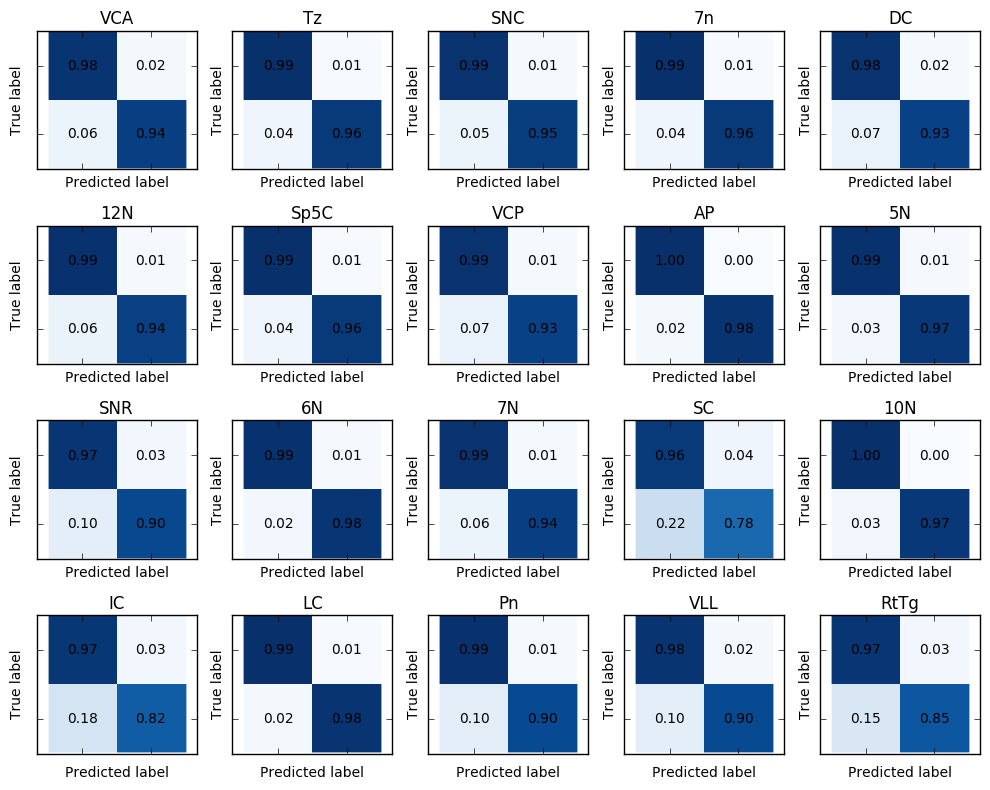

In [83]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = training_features[label]
    n_pos = len(features_pos)
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]
    elif train_sample_scheme == 2:
        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')]            
        for surr_l in structures:
            c = convert_to_surround_name(label, margin=margin, suffix=surr_l)
            if c in labels:
                neg_classes.append(c)
    elif train_sample_scheme in [8,9]:
        neg_classes = [label + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[label] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [84]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.955705138166


In [ ]:
# visualize training patches

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')
display_images_in_grids(patches, 5)

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)